In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pickle

def write_data_to_disk(file, data):
    with open(file, 'wb') as fid:
        pickle.dump(data, fid)


def load_data_from_disk(file):
    with open(file, 'rb') as fid:
        data = pickle.load(fid)
    return data

In [3]:
def ISC(r, t):
    if_r = r
    if_t = t
    alpha = 0.94
    beta = 2.37
    q = 0.33

    f0 = 1 / (1 + (q * (if_r ** alpha))) ** beta
    x = if_t / if_r

    q1 = 1 / (1 - f0)
    k = 1.23
    s = (f0 / 2) + ((1 - (f0 / 2)) / (1 + (q1 * (x ** (-k)))))
    S = round(s * 100, 2)
    return S

def isc_pacs_inside_year(pacs_X_dict):
    ''' Recebe un dict de pacs com fi  {pac1: fi1, pac2: fi2, ...}
        Gera um dict de isc de comparar todos os pacs que recebeu  { ref: {obj: isc } }
        {pr_1: {pt_1: isc_11, pt_2: isc_12, ...}, pr_2: {pt_1: isc_21, pt_2: isc_22, ...} }'''
    
    M = {}
    for pac_r, fi_r in pacs_X_dict.items(): 
        # print('{} ref: {}').format(pac_r, fi_r))
        r = fi_r
        m = {}
        for pac_t, fi_t in pacs_X_dict.items():
            # print('{} obj: {}').format(pac_t, fi_t))
            t = fi_t
            indice = ISC(r,t)
            # print('{} - {}:  {}'.format(pac_r, pac_t, indice))
            m[pac_t] = indice
        M[pac_r] = m   # matriz em dict
    # print('isc dict:', M)                                      # {pac_r: {pac_t: 59.24,.. }}
    # dm = pd.DataFrame.from_dict(M)  
    # rint(dm)  # imprime a matriz de isc do formato dataframe
    return M

In [4]:
def isc_m50_pacs(M_dict_isc):
    ''' Recebe um dict (matriz de isc's)
    {pr_1: {pt_1: isc_11, pt_2: isc_12}, pr_2: {pt_1: isc_21, pt_2: isc_22}}
    
    Gera um dict com isc's maiores que 50% no mesmo formato de [M_dict_isc]
    {pr_1: {pt_2: isc_12}, pr_2: {pt_1: isc_21}},
     onde isc_12 e isc_21 > 50% '''
    
    K = {}
    for pr, values in M_dict_isc.items():
        k = {}
        for po in values:
            if values[po] > 50:
                k[po] = values[po]
                K[pr] = k
    return K

def isc_m50_pacs_values(M_dict_isc):
    Kv = []
    for pr, values in M_dict_isc.items():
        for po in values:
            if values[po] > 50:
                Kv.append(values[po])
    return Kv

def isc_m50_pacs_v2(M_dict_isc):
    ''' Recebe um dict (matriz de isc's)
    {pr_1: {pt_1: isc_11, pt_2: isc_12}, pr_2: {pt_1: isc_21, pt_2: isc_22}}
    
    Gera um dict com isc's maiores que 50% no mesmo formato de [M_dict_isc]
    {(pr_1, pt_2): isc_12, (pr_2, pt_1): isc_21},
     onde isc_12 e isc_21 > 50% '''
    
    K = {}
    for pr, values in M_dict_isc.items():
        for po in values:
            if values[po] > 50:
                K[pr, po] = values[po]
    return K


In [5]:
def mean_isc_year(K_dict_v2):
    ''' Recebe um dict do tipo {(pr, po): isc1_m50, (pr, po): isc2_m50} da func isc_m50_pacs_v2
    calcula a media dos isc , a saída é um unico valor para uma matriz de um nao'''
    media = [] 
    for pr_o, value in K_dict_v2.items():
        media.append(value)

    mean = round(sum(media)/len(media), 2)
    # print(mean)
    return mean

def max_isc_year(K_dict):
#     Max_p = {}

    Im = {}
    for pr, values in K_dict.items():
        po_m = max(values, key=values.get)
        Im[pr, po_m] = values[po_m] # max de cada pac_r  
    # print('\nmax de cada pac_r', Im)

    pr_po_max = max(Im, key=Im.get)  # max de todos os pac_r

    Max_p = Im[pr_po_max]

    return Max_p


In [6]:
def main(revista):
    fi_pacs50 = load_data_from_disk('Dict_fi_pacs50art_years_revistas/' + revista+ '_dic_fi_pacs50art_years.pk')
    print(fi_pacs50)
    K_years = {}
    K_mean = {}
    K_max = {}

    for ano, pacs in fi_pacs50.items():
        print(ano)
        M = isc_pacs_inside_year(pacs)
        # print('\nisc dict: ', M)  # ****   
        
        K = isc_m50_pacs(M)
        
        K1= isc_m50_pacs_v2(M)
        
        K2 =isc_m50_pacs_values(M)
        # print('\nisc v2 > 50 dict: ', K2) # ****
        # print(pd.DataFrame.from_dict(K2, orient='index', columns=['isc >50']))
        print(K2)
        
        p_max = max_isc_year(K)
        p_mean = mean_isc_year(K1)
        
        K_years[ano]= K2
        K_mean[ano] = p_mean
        K_max[ano] = p_max

    #print(K_years)
    return K_years, K_mean, K_max


In [8]:
revista = 'PRD'
dict_data, dict_mean, dict_max = main(revista)
print(dict_data)

pm = pd.DataFrame.from_dict(dict_mean, orient='index', columns=['mean'])
pma = pd.DataFrame.from_dict(dict_max, orient='index', columns=['max'])

# pc = pd.concat([pm, pma], axis=1, sort=True)
# print(pc)
labels, data = [*zip(*dict_data.items())]
#print(labels)
# pc1 = pc['max']


#print(data)

{1986: {3.65: 0.71154, 4.5: 0.86, 11.1: 1.09353, 11.15: 1.06024, 11.3: 1.02857, 12.1: 1.03797, 12.4: 1.43103, 13.85: 0.85185, 14.4: 1.41935, 14.8: 0.84615, 98.8: 1.37838}, 1987: {3.65: 0.71, 3.7: 1.30769, 4.2: 0.61607, 4.5: 0.83333, 4.6: 1.30233, 11.1: 0.79429, 11.15: 0.84706, 11.3: 0.69697, 12.1: 1.79528, 12.15: 2.1831, 12.38: 0.89623, 12.4: 1.05882, 13.25: 0.90769, 13.4: 0.73077, 13.75: 1.07843, 13.85: 0.80405, 14.2: 1.26562, 14.4: 1.23333, 14.6: 1.93407, 14.8: 0.95475, 98.8: 1.39216}, 1988: {3.65: 0.75269, 3.7: 0.9863, 4.2: 0.64567, 4.5: 0.21538, 4.6: 0.89796, 11.1: 0.72938, 11.15: 0.86158, 11.17: 0.74783, 11.3: 0.79439, 11.4: 0.80392, 12.1: 1.31325, 12.15: 1.47619, 12.38: 0.83105, 12.4: 0.87701, 12.5: 0.56364, 13.1: 1.16949, 13.25: 0.91935, 13.4: 0.73684, 13.85: 1.15385, 14.2: 1.0678, 14.4: 1.02609, 14.6: 1.56604, 14.8: 1.48058, 98.8: 1.12346}, 1989: {3.65: 0.90769, 3.7: 0.7, 4.2: 0.40708, 4.5: 0.29412, 4.6: 0.72222, 11.1: 0.41954, 11.15: 0.5119, 11.17: 0.43636, 11.3: 0.46494, 12.1

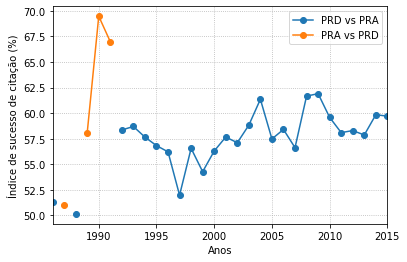

In [17]:
rev_isc = load_data_from_disk('XvsY_isc_revistas/PRDvsPRA_isc_years.pk')

def convert(rev_isc):
    g = {}
    for key, values in rev_isc.items():
        j = {}
        for k, val in values.items():
            j[int(k)] = val
        g[key]= j

    #print(g)
    return g

dit = convert(rev_isc)
d_rev = pd.DataFrame(dit)
dr = d_rev[50 < d_rev]
# dr
# print(dr)

dr.plot(ls='-', marker='o')
plt.xlabel('Anos')
plt.ylabel('Índice de sucesso de citação (%)')
plt.grid(linestyle=':')
plt.show()


In [16]:
pcc = pd.concat([pma, dr], axis=1, sort=True)

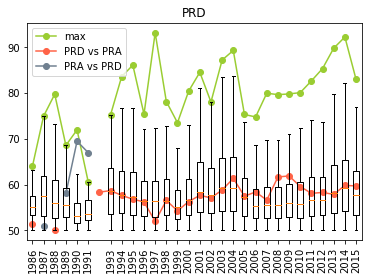

In [9]:
# dr.plot()
pcc.plot(ls='-', marker='o', color=['yellowgreen', 'tomato', 'slategray', 'burlywood'])

# plt.boxplot(data, positions=labels , showfliers=True, whis=2.6)
plt.boxplot(data, positions=labels , showfliers=False) # , whis=2.98)

plt.xticks(rotation='vertical')
plt.title(revista)
plt.show()


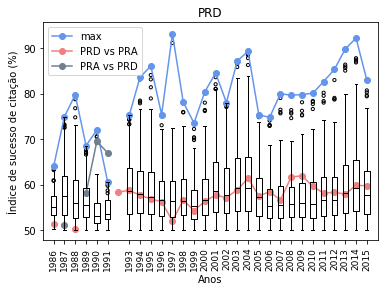

In [10]:
pcc.plot(ls='-', marker='o', color=['cornflowerblue', 'lightcoral', 'slategray', 'cadetblue', 'burlywood'])
medianp= dict(linewidth=1, color='black')
bplot = plt.boxplot(data,positions=labels, showfliers=False, medianprops=medianp)

# for patch in bplot['boxes'] :
#     patch.set_facecolor('black')

for i, v in dict_data.items():
    di = sorted(v, reverse=True)
    y = di[0:5]
    x = [i, i, i, i, i] 
    plt.scatter(x, y, s=10, marker='o', facecolors='none', edgecolors='k')

plt.title(revista)
plt.xlim(1985, 2016)
plt.xticks(rotation='vertical', fontsize=9)
plt.xlabel('Anos')
plt.ylabel('Índice de sucesso de citação (%)')
#plt.savefig('prb_f.png', dpi=300)
plt.show()


In [18]:
load_data_from_disk('Dict_fi_pacs50art_years_revistas/PRD_dic_fi_pacs50art_years.pk')


{1986: {3.65: 0.71154,
  4.5: 0.86,
  11.1: 1.09353,
  11.15: 1.06024,
  11.3: 1.02857,
  12.1: 1.03797,
  12.4: 1.43103,
  13.85: 0.85185,
  14.4: 1.41935,
  14.8: 0.84615,
  98.8: 1.37838},
 1987: {3.65: 0.71,
  3.7: 1.30769,
  4.2: 0.61607,
  4.5: 0.83333,
  4.6: 1.30233,
  11.1: 0.79429,
  11.15: 0.84706,
  11.3: 0.69697,
  12.1: 1.79528,
  12.15: 2.1831,
  12.38: 0.89623,
  12.4: 1.05882,
  13.25: 0.90769,
  13.4: 0.73077,
  13.75: 1.07843,
  13.85: 0.80405,
  14.2: 1.26562,
  14.4: 1.23333,
  14.6: 1.93407,
  14.8: 0.95475,
  98.8: 1.39216},
 1988: {3.65: 0.75269,
  3.7: 0.9863,
  4.2: 0.64567,
  4.5: 0.21538,
  4.6: 0.89796,
  11.1: 0.72938,
  11.15: 0.86158,
  11.17: 0.74783,
  11.3: 0.79439,
  11.4: 0.80392,
  12.1: 1.31325,
  12.15: 1.47619,
  12.38: 0.83105,
  12.4: 0.87701,
  12.5: 0.56364,
  13.1: 1.16949,
  13.25: 0.91935,
  13.4: 0.73684,
  13.85: 1.15385,
  14.2: 1.0678,
  14.4: 1.02609,
  14.6: 1.56604,
  14.8: 1.48058,
  98.8: 1.12346},
 1989: {3.65: 0.90769,
  3.7: 0